In [27]:
# Imports

import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import locale

from statsmodels.tsa.seasonal import MSTL


locale.setlocale(locale.LC_TIME, "pt_BR.UTF-8")
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams["mathtext.fontset"] = "custom"
matplotlib.rcParams["mathtext.bf"] = "Arial:bold"
matplotlib.rcParams["mathtext.it"] = "Arial:italic"

### Leitura dos Dados

In [28]:
df = pd.read_excel("../data/Desafio Inteligência (Cientista de Dados).xlsx")

### Limpeza dos Dados

In [29]:
df.categoria_veiculo = df.categoria_veiculo.replace(
    {"IntermediÃ¡rio": "Intermediário", "EconÃ´mico": "Econômico"}
)

for column_name in df.columns:
    if "Unnamed" in column_name:
        df.drop(column_name, axis=1, inplace=True)

df.drop(["cidade", "estado"], axis=1, inplace=True)

df.id_loja = df.id_loja.str.replace("LJ_", "Loja ")

rename_columns = {
    "data_inicio_locacao": "Data de Início da Locação",
    "duracao_locacao": "Duração da Locação",
    "dias_antecedencia": "Dias de Antecedência",
    "diaria_media": "Diária Média",
    "valor_total_locacao": "Valor Total da Locação",
    "id_loja": "ID da Loja",
    "id_contrato": "ID do Contrato",
    "categoria_veiculo": "Categoria do Veículo",
}

df.rename(columns=rename_columns, inplace=True)

numerical_columns = [
    "Duração da Locação",
    "Dias de Antecedência",
    "Diária Média",
    "Valor Total da Locação",
]
categorical_columns = ["ID da Loja", "ID do Contrato", "Categoria do Veículo"]

### Estatísticas Gerais

1. Qual a duração média de uma locação?
R: 6 dias

2. Qual o valor médio arrecadado por contrato?
R$ 761.95

3. Com quantos dias de antecedência, em média, os clientes reservam?
R: 15 dias


In [30]:
# Display Dataframe
# Visualização das principais estatísticas do conjunto de dados

display(df.head())
display(df.info())
display(df.describe())

,ID do Contrato,Data de Início da Locação,Duração da Locação,ID da Loja,Dias de Antecedência,Categoria do Veículo,Diária Média,Valor Total da Locação
0,CTR0000001,2022-01-27,8,Loja 01,13,Econômico,91.22,729.76
1,CTR0000002,2022-01-31,9,Loja 01,9,Intermediário,78.70,708.30
2,CTR0000003,2022-01-10,7,Loja 01,16,SUV,143.14,1001.98
3,CTR0000004,2022-01-28,7,Loja 01,4,Intermediário,135.86,951.02
4,CTR0000005,2022-01-28,9,Loja 01,9,Intermediário,104.02,936.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140249 entries, 0 to 140248
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID do Contrato             140249 non-null  object        
 1   Data de Início da Locação  140249 non-null  datetime64[ns]
 2   Duração da Locação         140249 non-null  int64         
 3   ID da Loja                 140249 non-null  object        
 4   Dias de Antecedência       140249 non-null  int64         
 5   Categoria do Veículo       140249 non-null  object        
 6   Diária Média               140249 non-null  float64       
 7   Valor Total da Locação     140249 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 8.6+ MB


None

,Data de Início da Locação,Duração da Locação,Dias de Antecedência,Diária Média,Valor Total da Locação
count,140249,140249.000000,140249.000000,140249.000000,140249.000000
mean,2023-03-13 18:31:13.553465600,6.347439,15.019287,120.045161,761.950563
min,2022-01-01 00:00:00,1.000000,0.000000,-5.190000,-31.140000
25%,2022-08-01 00:00:00,5.000000,7.000000,99.750000,516.800000
50%,2023-02-24 00:00:00,6.000000,15.000000,120.140000,728.560000
75%,2023-11-03 00:00:00,8.000000,23.000000,140.220000,970.740000
max,2024-06-30 00:00:00,16.000000,30.000000,259.860000,2875.800000
std,NaN,2.271802,8.943597,30.002451,339.808277


### Histogramas

/tmp/ipykernel_723276/3698164701.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


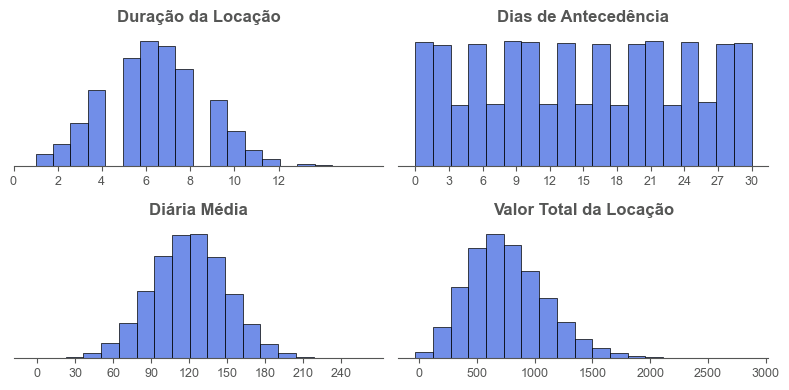

In [31]:
# Auxiliary Functions


def sturges_bins(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n <= 1:
        return 1, np.inf

    k = math.ceil(math.log2(n)) + 1
    data_range = x.max() - x.min()
    h = data_range / k if data_range > 0 else np.inf
    return k, h


def configure_histogram(ax, title_text):
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=9, color="#555655")
    ax.get_yaxis().set_visible(False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        0.5,
        1.1,
        title_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="semibold",
        color="#555655",
        ha="center",  # centraliza horizontalmente
    )

    plt.tight_layout()


# Plot

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 4), constrained_layout=True)
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    k, h = sturges_bins(df.loc[:, col].values)
    sns.histplot(data=df, x=col, ax=axes[idx], bins=k, binwidth=h, linewidth=0.5, color="#4169E1")

    if col == "Duração da Locação":
        axes[idx].set_xticks(range(0, 14, 2))
    elif col == "Dias de Antecedência":
        axes[idx].set_xticks(range(0, 31, 3))
    elif col == "Diária Média":
        axes[idx].set_xticks(range(0, 251, 30))

    configure_histogram(ax=axes[idx], title_text=col)

plt.savefig("../img/results/histograms.png", dpi=600)

### Gráficos de Pareto

/tmp/ipykernel_723276/592600941.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_723276/592600941.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


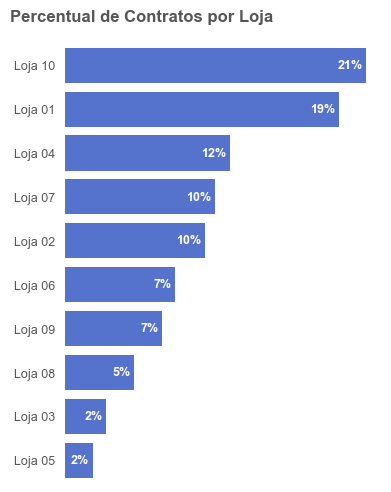

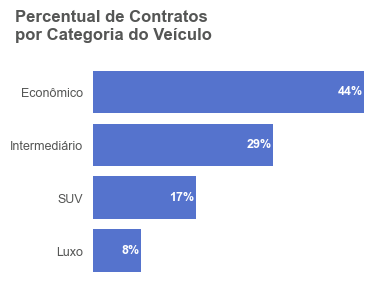

In [32]:
# Auxiliary Functions


def configure_plot(ax, title_text, title_loc):
    ax.tick_params(color="#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.setp(ax.get_yticklabels(), fontsize=9, color="#555655")
    ax.get_xaxis().set_visible(False)
    ax.tick_params(left=False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        *title_loc,
        title_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="semibold",
        color="#555655",
    )

    for p in ax.patches:
        percent = int(p.get_width() * 100)
        text = f"{percent}%"

        x = p.get_width() - 0.0025
        y = p.get_y() + p.get_height() / 2

        ax.text(
            x,
            y,
            text,
            fontweight="semibold",
            ha="right",
            va="center",
            fontsize=9,
            color="white",
        )

    plt.tight_layout()


# Plot

for col in categorical_columns:
    if col != "ID do Contrato":
        if col == "ID da Loja":
            title_text = "Percentual de Contratos por Loja"
            title_loc = (-0.175, 1.05)
            file_name = "store"
            fig, ax = plt.subplots(figsize=(4, 5), constrained_layout=True)
        else:
            title_text = "Percentual de Contratos \npor " + col
            title_loc = (-0.275, 1.125)
            file_name = "vehicle_category"
            fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

        rel_freq = df[col].value_counts(normalize=True).reset_index()
        rel_freq.columns = [col, "percent"]

        order = rel_freq[col]

        sns.barplot(
            data=rel_freq,
            y=col,
            x="percent",
            order=order,
            ax=ax,
            color="#4169E1",
        )

        configure_plot(ax=ax, title_text=title_text, title_loc=title_loc)

        plt.savefig(f"../img/results/contracts_by_{file_name}.png", dpi=300)

### Análise Temporal

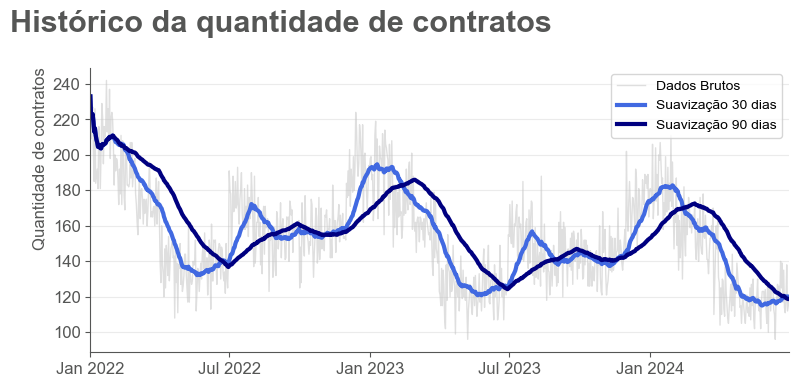

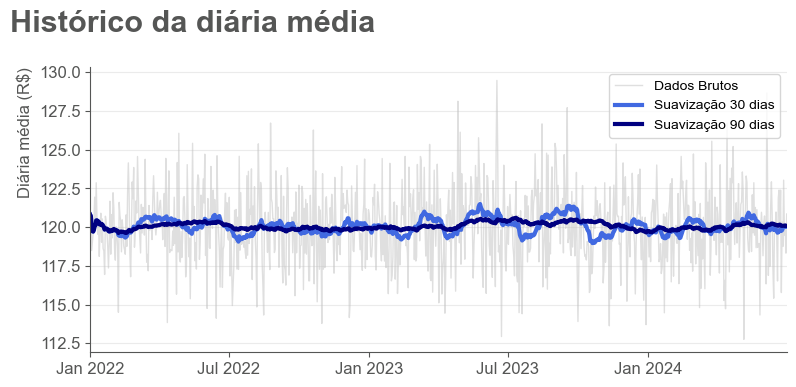

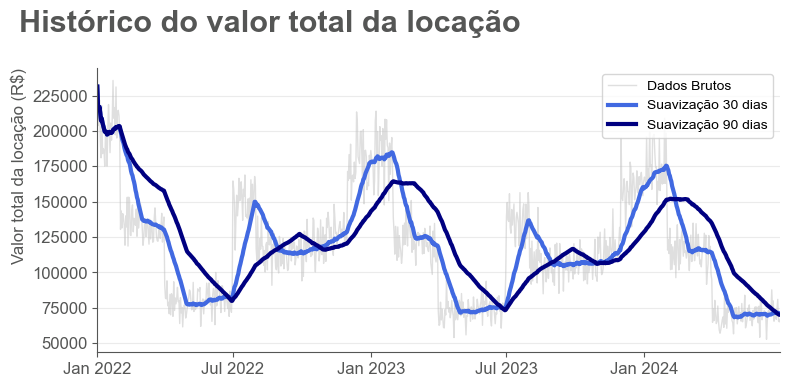

In [36]:
# Dados Brutos e Médias Móveis (Suavização)


def config_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", loc="upper right")

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )


def time_series_plot(
    df: pd.DataFrame, title: str, column: str, y_label: str, filename: str = None
):
    # Processamento dos Dados
    if column == "ID do Contrato":
        agg_function = "count"
    elif column == "Valor Total da Locação":
        agg_function = "sum"
    else:
        agg_function = "mean"

    df_time_series = (
        df.groupby(df["Data de Início da Locação"].dt.date)
        .agg({column: agg_function})
        .reset_index()
    )
    df_time_series.rename(
        columns={"Data de Início da Locação": "Data", column: "Dados Brutos"},
        inplace=True,
    )
    df_time_series["Data"] = pd.to_datetime(df_time_series["Data"])
    min_date = df_time_series["Data"].min()
    max_date = df_time_series["Data"].max()
    df_time_series.set_index("Data", inplace=True)

    # Cálculo
    df_time_series["Suavização 30 dias"] = (
        df_time_series["Dados Brutos"].rolling(window="30D").mean()
    )
    df_time_series["Suavização 90 dias"] = (
        df_time_series["Dados Brutos"].rolling(window="90D").mean()
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))

    colors = {
        "Dados Brutos": "#C0C0C080",
        "Suavização 30 dias": "#4169E1",
        "Suavização 90 dias": "#000080",
    }
    widths = {"Dados Brutos": 1, "Suavização 30 dias": 3, "Suavização 90 dias": 3}

    for series_name in colors.keys():
        ax.plot(
            df_time_series.index,
            df_time_series[series_name],
            color=colors[series_name],
            linewidth=widths[series_name],
            label=series_name,
        )

    config_plot(ax, title, y_label, min_date, max_date)

    plt.tight_layout()

    if filename:
        plt.savefig(f"../img/results/{filename}.png", dpi=300)


# Execution

time_series_plot(
    df,
    title="Histórico da quantidade de contratos",
    column="ID do Contrato",
    y_label="Quantidade de contratos",
    filename="history of the number of contracts".replace(" ", "_"),
)

time_series_plot(
    df,
    title="Histórico da diária média",
    column="Diária Média",
    y_label="Diária média (R$)",
    filename="history of the average daily rate".replace(" ", "_"),
)

time_series_plot(
    df,
    title="Histórico do valor total da locação",
    column="Valor Total da Locação",
    y_label="Valor total da locação (R$)",
    filename="total rental value history".replace(" ", "_"),
)

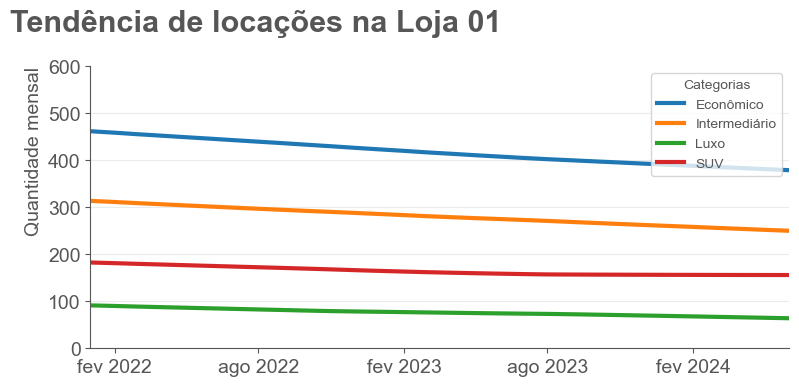

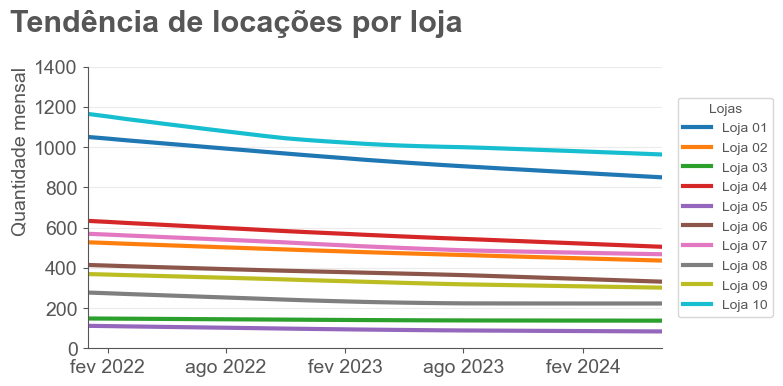

In [34]:
# Auxiliary Functions


def change_the_granularity_to_month(df: pd.DataFrame) -> pd.DataFrame:

    # Define as agregações a serem feitas
    aggregations = {
        "ID do Contrato": "count",
        "Diária Média": "mean",
        "Valor Total da Locação": "sum",
    }

    # Converte a coluna de data e cria a coluna 'mes'
    df_copy = df.copy()
    df_copy["Data de Início da Locação"] = pd.to_datetime(
        df_copy["Data de Início da Locação"]
    )
    df_copy["mes"] = df_copy["Data de Início da Locação"].dt.to_period("M")

    # Agrupa por mês, loja e categoria
    df_mensal = (
        df_copy.groupby(["mes", "ID da Loja", "Categoria do Veículo"])
        .agg(aggregations)
        .reset_index()
    )

    # Renomeia a coluna para refletir a contagem de contratos
    df_mensal = df_mensal.rename(columns={"ID do Contrato": "quantidade_contratos"})

    return df_mensal


def get_mstl_decomposition(df_single_series: pd.DataFrame, column: str):

    df_mstl = df_single_series[["mes", column]].copy()
    df_mstl["Data"] = df_mstl["mes"].dt.to_timestamp()
    df_mstl = df_mstl.set_index("Data")

    # Seleciona os períodos de sazonalidade com base no tamanho dos dados
    if len(df_mstl) >= 2 * 12:
        periods = [6, 12]
    elif len(df_mstl) >= 2 * 6:
        periods = [3, 6]
    else:
        periods = 3

    decomposition = MSTL(df_mstl[column], periods=periods).fit()

    return decomposition


def configure_plot(
    ax,
    title_text,
    y_label,
    legend_title,
    min_date,
    max_date,
    y_upper_lim,
    legend_options,
    title_loc,
):
    ax.set_xlim(min_date, max_date)
    ax.set_ylim([0, int(1.1 * y_upper_lim)])

    date_format = mdates.DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.grid(axis="y", alpha=0.25)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=14, color="#555655"
    )

    leg = ax.legend(title=legend_title, labelcolor="#555655", **legend_options)
    leg.get_title().set_color("#555655")

    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=14, color="#555655")
    ax.text(
        *title_loc,
        title_text,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )

    ax.set_ylim([0, max(ax.get_yticks())])
    plt.tight_layout()


def plot_trends_by_category(df_monthly, stores, vehicles):

    for store in stores:
        fig, ax = plt.subplots(figsize=(8, 4))
        y_upper_lim = 0

        store_data = df_monthly[df_monthly["ID da Loja"] == store]
        if store_data.empty:
            plt.close(fig)
            continue

        min_date = store_data["mes"].min().to_timestamp()
        max_date = store_data["mes"].max().to_timestamp()

        for vehicle in vehicles:
            df_filtered = store_data[
                store_data["Categoria do Veículo"] == vehicle
            ].copy()
            if df_filtered.empty:
                continue

            decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
            if decomposition is None:
                continue

            sns.lineplot(data=decomposition.trend, label=vehicle, ax=ax, linewidth=3)
            y_upper_lim = max(y_upper_lim, decomposition.trend.max())

        title = f"Tendência de locações na {store.replace('LJ', 'Loja')}"
        legend_opts = {"loc": "upper right"}
        configure_plot(
            ax,
            title,
            "Quantidade mensal",
            "Categorias",
            min_date,
            max_date,
            y_upper_lim,
            legend_opts,
            title_loc=(-0.115, 1.125),
        )

        plt.savefig(f"../img/results/trend_amount_{store}.png", dpi=300)

        if store != "Loja 01":
            plt.close(fig)


def plot_trends_by_store(df_monthly, stores):

    df_by_store = (
        df_monthly.groupby(["mes", "ID da Loja"])["quantidade_contratos"]
        .sum()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    y_upper_lim = 0

    min_date = df_by_store["mes"].min().to_timestamp()
    max_date = df_by_store["mes"].max().to_timestamp()

    for store in stores:
        df_filtered = df_by_store[df_by_store["ID da Loja"] == store].copy()
        if df_filtered.empty:
            continue

        decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
        if decomposition is None:
            continue

        sns.lineplot(
            data=decomposition.trend,
            label=store.replace("LJ ", "Loja "),
            ax=ax,
            linewidth=3,
        )
        y_upper_lim = max(y_upper_lim, decomposition.trend.max())

    title = "Tendência de locações por loja"
    legend_opts = {"loc": "center left", "bbox_to_anchor": (1.015, 0.5)}
    configure_plot(
        ax,
        title,
        "Quantidade mensal",
        "Lojas",
        min_date,
        max_date,
        y_upper_lim,
        legend_opts,
        title_loc=(-0.135, 1.125),
    )

    plt.savefig("../img/results/trend_amount.png", bbox_inches="tight", dpi=300)


# Execution

# Data Preparation
df_monthly = change_the_granularity_to_month(df.copy())
stores = sorted(df["ID da Loja"].unique().tolist())
vehicles = sorted(df["Categoria do Veículo"].unique().tolist())

# Graph Generation
plot_trends_by_category(df_monthly, stores, vehicles)
plot_trends_by_store(df_monthly, stores)

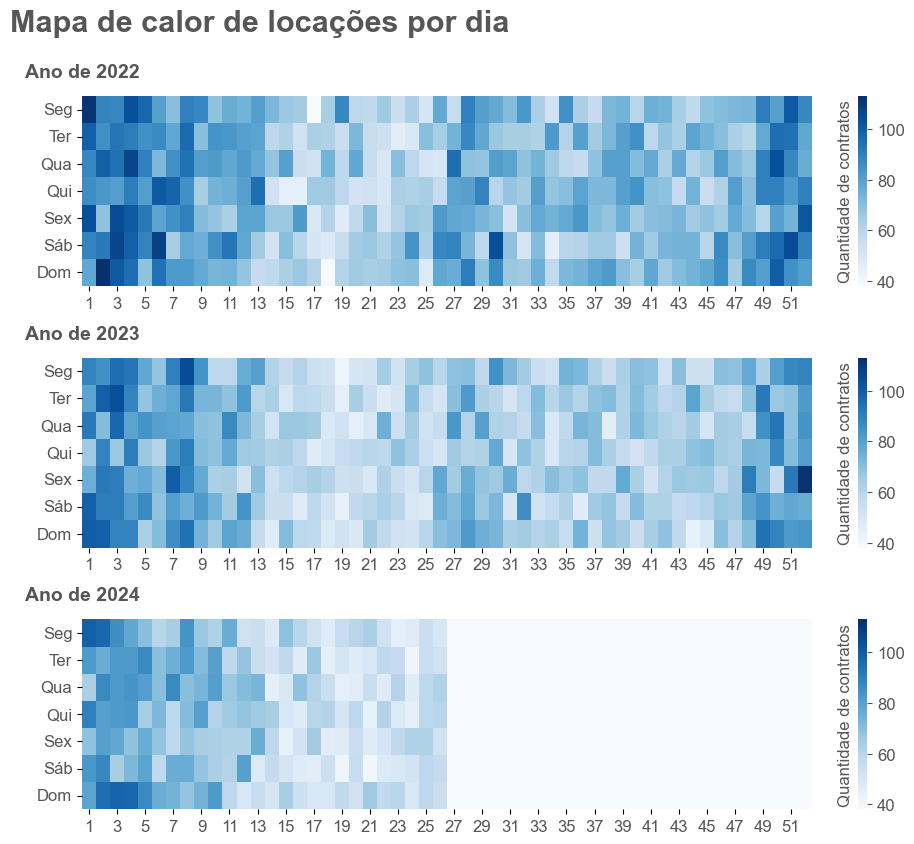

In [35]:
# Filtra Dataframe

# df_filtered = df.copy()
# df_filtered = df[df["ID da Loja"] == "Loja 05"].copy()
df_filtered = df[df["Categoria do Veículo"] == "Econômico"].copy()

# Processamento dos Dados

daily_counts = (
    df_filtered.groupby(df_filtered["Data de Início da Locação"].dt.date)
    .size()
    .reset_index(name="contagens")
)
daily_counts = daily_counts.rename(columns={"Data de Início da Locação": "data"})
daily_counts["data"] = pd.to_datetime(daily_counts["data"])

daily_counts["ano"] = daily_counts["data"].dt.year
daily_counts["semana_do_ano"] = daily_counts["data"].dt.isocalendar().week
daily_counts["dia_da_semana"] = daily_counts["data"].dt.dayofweek

vmin = daily_counts["contagens"].min()
vmax = daily_counts["contagens"].max()

anos = sorted(daily_counts["ano"].unique())

# Plot

fig, axes = plt.subplots(len(anos), 1, figsize=(10, 8), squeeze=False)

for i, ano in enumerate(anos):
    ax = axes[i, 0]
    df_year = daily_counts[daily_counts["ano"] == ano]

    # Cria a matriz (pivot table) para o heatmap
    # Linhas: dia da semana, Colunas: semana do ano, Valores: contagem de contratos
    heatmap_data = df_year.pivot_table(
        index="dia_da_semana",
        columns="semana_do_ano",
        values="contagens",
        fill_value=0,  # Preenche dias sem locações com 0
    )

    # Garante que todas as semanas (1-53) e dias (0-6) estejam presentes na matriz
    heatmap_data = heatmap_data.reindex(
        index=range(7), columns=range(1, 53), fill_value=0
    )

    # Desenha o mapa de calor usando os limites globais vmin e vmax
    cbar = sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap="Blues",
        linewidths=0,
        vmin=vmin,
        vmax=vmax,
    )

    # Configurações do Plot

    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    cbar = cbar.collections[0].colorbar
    cbar.set_label("Quantidade de contratos", size=12, color="#555655")
    cbar.ax.yaxis.set_label_position("left")
    cbar.ax.tick_params(labelsize=12, colors="#555655")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(
        0.0,
        1.1,
        f"Ano de {ano}",
        transform=ax.transAxes,
        fontsize=14,
        fontweight="semibold",
        color="#555655",
        ha="center",
    )

    dias_semana_labels = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
    ax.set_yticklabels(dias_semana_labels, rotation=0)

fig.text(
    0.25,
    1.05,
    "Mapa de calor de locações por dia",
    ha="center",
    va="top",
    fontsize=22,
    fontweight="semibold",
    color="#555655",
)

plt.tight_layout()

plt.savefig("../img/results/heat_map.png", dpi=300, bbox_inches="tight")